# Prepartions

In [1]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
from sklearn.linear_model import HuberRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
import gc




In [3]:
df_final = pd.read_csv("C:/Users/CMert/Documents/Data bachelorprojekt/The complete dataframe/df_final_cleaned_combined_2_endofmonth.csv")

df_final['Adj Close t+1'] = df_final.groupby("Symbol")["Adj Close"].shift(-1)

df_final = df_final.dropna(subset=['Adj Close t+1']).reset_index(drop=True)

df_final = df_final[df_final['1-month momentum'] != 0]

df_final['Date'] = pd.to_datetime(df_final['Date'])

df_final = df_final.sort_values(by='Date').reset_index(drop=True)

df_final = df_final[df_final['Adj Close t+1'] <= df_final["Adj Close t+1"].quantile(0.985)]



variables = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends',
       'Stock Splits', 'Market capitalization', 'Revenue', 'Earnings',
       'P/E ratio', 'P/B ratio', 'Operating Margin', 'EPS',
       'Shares Outstanding', 'Total assets', 'Total liabilities', 'Total debt',
       'Cash on Hand', 'Net assets', '1-month momentum', '6-month momentum',
       '12-month momentum', '36-month momentum', 'Book-to-market', 'Size']

df_final[variables] = df_final[variables].replace([np.inf, -np.inf], np.nan)

non_negative_variables = [
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends',
    'Stock Splits', 'Market capitalization', 'Revenue', 'EPS',
    'Shares Outstanding', 'Total assets', 'Total liabilities', 'Total debt',
    'Cash on Hand', 'Net assets'
]

df_final[non_negative_variables] = df_final[non_negative_variables].applymap(lambda x: max(x, 0))


funda_cols = [
    'Market capitalization', 'Revenue', 'Earnings', 'P/E ratio', 'P/B ratio',
    'Operating Margin', 'EPS', 'Shares Outstanding', 'Total assets',
    'Total liabilities', 'Total debt', 'Cash on Hand', 'Net assets'
]

df_final[funda_cols] = (
    df_final.groupby('Symbol')[funda_cols]
      .shift(12))

df_final = df_final.dropna(subset=variables).reset_index(drop=True)



In [4]:
df_final

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Sector,...,Cash on Hand,Net assets,1-month momentum,6-month momentum,12-month momentum,36-month momentum,Book-to-market,Size,Symbol,Adj Close t+1
0,1997-02-28,0.150670,0.150670,0.145089,0.145089,0.122524,121878400.0,0.0,0.0,Technology,...,1.740000e+09,0.000000e+00,-0.002828,0.006597,0.012723,0.102261,10.516756,0.000000,AAPL,0.137604
1,1997-02-28,6.937500,6.937500,6.812500,6.812500,2.242910,9400.0,0.0,0.0,Consumer Discretionary,...,4.700000e+06,8.849816e+07,-0.022543,0.019197,0.394677,1.072677,0.668527,18.906044,SGC,2.140023
2,1997-02-28,39.187500,39.312500,38.375000,39.312500,32.637779,494200.0,0.0,0.0,Finance,...,1.400000e+08,2.293864e+09,2.040556,13.065813,25.626753,3.814121,0.645497,22.474418,MTG,29.368822
3,1997-02-28,10.625000,10.937500,10.562500,10.875000,10.332757,159200.0,0.0,0.0,Technology,...,5.300000e+06,9.747199e+07,-1.425210,6.354053,6.057135,5.700832,0.062723,19.351977,NICE,9.738921
4,1997-02-28,31.500000,31.500000,30.687500,30.687500,9.806581,22000.0,0.0,0.0,Finance,...,6.967000e+07,0.000000e+00,1.078525,3.761210,6.900859,4.914822,0.355534,21.321768,MCY,9.791734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700452,2024-08-30,38.150002,38.590000,37.830002,38.580002,38.580002,539900.0,0.0,0.0,Utilities,...,2.700000e+08,3.020000e+09,-1.464996,3.577999,5.195873,-2.139236,0.021338,21.436014,WES,38.299999
700453,2024-08-30,30.900000,31.200001,30.209999,30.440001,30.440001,2364900.0,0.0,0.0,Consumer Discretionary,...,6.953566e+08,1.731511e+09,1.089708,0.321186,15.223827,30.727109,0.105255,22.685456,HTHT,29.340000
700454,2024-08-30,6.690000,6.880000,6.670000,6.860000,6.860000,4055300.0,0.0,0.0,Technology,...,3.700000e+08,5.990000e+09,0.120000,0.380000,-3.950000,13.850000,0.341980,21.832332,CLVT,6.550000
700455,2024-08-30,51.099998,51.250000,49.590000,50.919998,50.919998,1494400.0,0.0,0.0,Technology,...,3.700000e+08,1.760000e+09,-1.520000,14.780001,4.780000,-2.470000,-0.115780,20.748237,CLS,43.490002


# The sampling algorithm

In [5]:

def recursive_rolling_method(data, initial_date, date_column='Date', 
         train_period = 24, val_period = 24, test_period = 12, freq = 'months'):
    
                
    train_indices_list = []
    val_indices_list = []
    test_indices_list = []

    
    # Define initial interval
    start_train = initial_date
    end_train = start_train + relativedelta(**{freq: train_period})
    
    start_val = end_train + relativedelta(months=1)
    end_val = start_val + relativedelta(**{freq: val_period})
    
    start_test = end_val + relativedelta(months=1)
    end_test = start_test + relativedelta(**{freq: test_period})

    
    while start_test  < data[date_column].max():   
        cur_train_indices = list(data[(data[date_column] >= start_train) & 
                              (data[date_column] < end_train)].index)

        cur_val_indices = list(data[(data[date_column] >= start_val) & 
                                    (data[date_column] < end_val)].index)

        cur_test_indices = list(data[(data[date_column] >= start_test) & 
                                    (data[date_column] < end_test)].index)

        
        print("    Train period:",start_train, "-" , end_train, 
            " || Val period:",start_val, "-" , end_val, 
            " || Test period", start_test, "-", end_test,
            " || Train contains", len(cur_train_indices),
            " || Val contains", len(cur_val_indices) , 
            " || Test contains", len(cur_test_indices))

        train_indices_list.append(cur_train_indices)
        val_indices_list.append(cur_val_indices)
        test_indices_list.append(cur_test_indices)
        
        
        # Define next interval
        
        filler_unit = 1
        start_train = start_train + relativedelta(**{freq: filler_unit}) #  -  this only goes one period ahead for each interval, so they overlap
        
        # start_train = end_test
        end_train = start_train + relativedelta(**{freq: train_period})  
        
        start_val = end_train + relativedelta(months=1)
        end_val = start_val + relativedelta(**{freq: val_period})
            
        start_test = end_val + relativedelta(months=1)
        end_test = start_test + relativedelta(**{freq: test_period})

    # Ensure we have the same output as sklearn sampling packages, since we will use its regressors
    index_output = [(train,val,test) for train,val,test in zip(train_indices_list,val_indices_list,test_indices_list)]
    
    return index_output


In [5]:
# Create the top and bottom firms by market cap:

top_symbols = (
    df_final.groupby('Symbol')['Market capitalization'].last() 
    .nlargest(500)  
    .index 
)


df_top_500 = df_final[df_final['Symbol'].isin(top_symbols)].reset_index(drop=True)



bottom_symbols = (
    df_final.groupby('Symbol')['Market capitalization'].last() 
    .nsmallest(500)  
    .index 
)


df_bottom_500 = df_final[df_final['Symbol'].isin(bottom_symbols)].reset_index(drop=True)

In [6]:
df_final.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividends', 'Stock Splits', 'Sector', 'Industry',
       'Market capitalization', 'Revenue', 'Earnings', 'P/E ratio',
       'P/B ratio', 'Operating Margin', 'EPS', 'Shares Outstanding',
       'Total assets', 'Total liabilities', 'Total debt', 'Cash on Hand',
       'Net assets', '1-month momentum', '6-month momentum',
       '12-month momentum', '36-month momentum', 'Book-to-market', 'Size',
       'Symbol', 'Adj Close t+1'],
      dtype='object')

# PLS algorithm for all stocks

In [6]:

X = df_final[['Date'] + variables]
y = df_final["Adj Close t+1"]

X['Date'] = pd.to_datetime(X['Date'])

initial_date = X['Date'].min() 

predictions = []
y_test_list = []
dates = []
numofc_time = {}


numofc = list(range(1, 28))


for split_num, (train_index, val_index, test_index) in enumerate(recursive_rolling_method(X,initial_date,date_column='Date',train_period=8,val_period=3,test_period=1,freq='years')):
    X_train = X.loc[train_index].drop('Date', axis=1)
    y_train = y.loc[train_index]

    X_val = X.loc[val_index].drop('Date', axis=1)
    y_val = y.loc[val_index]

    X_test = X.loc[test_index].drop('Date', axis=1)
    y_test = y.loc[test_index]
    
    mse = np.full((len(numofc),1), np.nan, dtype=np.float32)
    
   
    for chars in range(len(numofc)):
        pls_val = PLSRegression(n_components=numofc[chars])
        
        pls_val.fit(X_train, y_train)
        val_pred = pls_val.predict(X_val)
        
        mse[chars,0] = mean_squared_error(y_val, val_pred)

        
    best_numofc = numofc[np.argmin(mse)]
    
    
    pls = PLSRegression(n_components=best_numofc)
    pls.fit(X_train, y_train)  
    
    preds = pls.predict(X_test)
    
    
    predictions.append(preds)
    dates.append(X.loc[y_test.index, 'Date'])
    y_test_list.append(y_test)
    
   
    
    
    test_date = X.loc[y_test.index, 'Date'].iloc[-1]
    numofc_time[f"numpc.{test_date.strftime('%Y-%m-%d')}"] = best_numofc
    
    del X_train, y_train, X_val, y_val, pls, preds
    gc.collect()
    
    print(f"Completed split {split_num + 1}")


predictions_all = np.concatenate(predictions, axis=0)
y_test_list_all = pd.concat(y_test_list, axis=0)
dates_all = pd.concat(dates, axis=0)


R2oos_PLS = 1 - np.sum(np.power(y_test_list_all - predictions_all, 2)) / np.sum(np.power(y_test_list_all, 2))
print("R2_oos PLS: ", R2oos_PLS)


    Train period: 1997-02-28 00:00:00 - 2005-02-28 00:00:00  || Val period: 2005-03-28 00:00:00 - 2008-03-28 00:00:00  || Test period 2008-04-28 00:00:00 - 2009-04-28 00:00:00  || Train contains 125811  || Val contains 60364  || Test contains 22228
    Train period: 1998-02-28 00:00:00 - 2006-02-28 00:00:00  || Val period: 2006-03-28 00:00:00 - 2009-03-28 00:00:00  || Test period 2009-04-28 00:00:00 - 2010-04-28 00:00:00  || Train contains 131822  || Val contains 63246  || Test contains 22915
    Train period: 1999-02-28 00:00:00 - 2007-02-28 00:00:00  || Val period: 2007-03-28 00:00:00 - 2010-03-28 00:00:00  || Test period 2010-04-28 00:00:00 - 2011-04-28 00:00:00  || Train contains 138129  || Val contains 66069  || Test contains 23302
    Train period: 2000-02-28 00:00:00 - 2008-02-28 00:00:00  || Val period: 2008-03-28 00:00:00 - 2011-03-28 00:00:00  || Test period 2011-04-28 00:00:00 - 2012-04-28 00:00:00  || Train contains 145727  || Val contains 68275  || Test contains 24233
    

# PLS algorithm for top 500 stocks

In [ ]:

X = df_top_500[['Date'] + variables]
y = df_top_500['Adj Close t+1']


X['Date'] = pd.to_datetime(X['Date'])

initial_date = X['Date'].min() 

predictions = []
y_test_list = []
dates = []
numofc_time = {}


numofc = list(range(1, 28))


for split_num, (train_index, val_index, test_index) in enumerate(recursive_rolling_method(X,initial_date,date_column='Date',train_period=8,val_period=3,test_period=1,freq='years')):
    X_train = X.loc[train_index].drop('Date', axis=1)
    y_train = y.loc[train_index]

    X_val = X.loc[val_index].drop('Date', axis=1)
    y_val = y.loc[val_index].astype('float32')

    X_test = X.loc[test_index].drop('Date', axis=1)
    y_test = y.loc[test_index]
    
    mse = np.full((len(numofc),1), np.nan, dtype=np.float32)
    
   
    for chars in range(len(numofc)):
        pls_val = PLSRegression(n_components=numofc[chars])
        
        pls_val.fit(X_train, y_train)
        val_pred = pls_val.predict(X_val)
        
        mse[chars,0] = mean_squared_error(y_val, val_pred)

        
    best_numofc = numofc[np.argmin(mse)]
    
    
    pls = PLSRegression(n_components=best_numofc)
    pls.fit(X_train, y_train)  
    
    preds = pls.predict(X_test)
    
    
    predictions.append(preds)
    dates.append(X.loc[y_test.index, 'Date'])
    y_test_list.append(y_test)
    
    
    test_date = X.loc[y_test.index, 'Date'].iloc[-1]
    numofc_time[f"numpc.{test_date.strftime('%Y-%m-%d')}"] = best_numofc
    
    del X_train, y_train, X_val, y_val, pls, preds
    gc.collect()
    
    print(f"Completed split {split_num + 1}")


predictions_all = np.concatenate(predictions, axis=0)
y_test_list_all = pd.concat(y_test_list, axis=0)
dates_all = pd.concat(dates, axis=0)


R2oos_PLS_top = 1 - np.sum(np.power(y_test_list_all - predictions_all, 2)) / np.sum(np.power(y_test_list_all, 2))
print("R2_oos PLS Top 500: ", R2oos_PLS_top)

    Train period: 1997-02-28 00:00:00 - 2005-02-28 00:00:00  || Val period: 2005-03-28 00:00:00 - 2008-03-28 00:00:00  || Test period 2008-04-28 00:00:00 - 2009-04-28 00:00:00  || Train contains 29361  || Val contains 13204  || Test contains 4636
    Train period: 1998-02-28 00:00:00 - 2006-02-28 00:00:00  || Val period: 2006-03-28 00:00:00 - 2009-03-28 00:00:00  || Test period 2009-04-28 00:00:00 - 2010-04-28 00:00:00  || Train contains 30401  || Val contains 13524  || Test contains 4741
    Train period: 1999-02-28 00:00:00 - 2007-02-28 00:00:00  || Val period: 2007-03-28 00:00:00 - 2010-03-28 00:00:00  || Test period 2010-04-28 00:00:00 - 2011-04-28 00:00:00  || Train contains 31579  || Val contains 13863  || Test contains 4803
    Train period: 2000-02-28 00:00:00 - 2008-02-28 00:00:00  || Val period: 2008-03-28 00:00:00 - 2011-03-28 00:00:00  || Test period 2011-04-28 00:00:00 - 2012-04-28 00:00:00  || Train contains 32931  || Val contains 14151  || Test contains 4951
    Train pe

# PLS algorithm for bottom 500 stocks

In [64]:

X = df_bottom_500[['Date'] + variables]
y = df_bottom_500['Adj Close t+1']

X['Date'] = pd.to_datetime(X['Date'])

initial_date = X['Date'].min() 

predictions = []
y_test_list = []
dates = []
numofc_time = {}


numofc = list(range(1, 28))


for split_num, (train_index, val_index, test_index) in enumerate(recursive_rolling_method(X,initial_date,date_column='Date',train_period=8,val_period=3,test_period=1,freq='years')):
    X_train = X.loc[train_index].drop('Date', axis=1)
    y_train = y.loc[train_index]

    X_val = X.loc[val_index].drop('Date', axis=1)
    y_val = y.loc[val_index].astype('float32')

    X_test = X.loc[test_index].drop('Date', axis=1)
    y_test = y.loc[test_index]
    
    mse = np.full((len(numofc),1), np.nan, dtype=np.float32)
    
   
    for chars in range(len(numofc)):
        pls_val = PLSRegression(n_components=numofc[chars])
        
        pls_val.fit(X_train, y_train)
        val_pred = pls_val.predict(X_val)
        
        mse[chars,0] = mean_squared_error(y_val, val_pred)

        
    best_numofc = numofc[np.argmin(mse)]
    
    
    pls = PLSRegression(n_components=best_numofc)
    pls.fit(X_train, y_train)  
    
    preds = pls.predict(X_test)
    
    
    predictions.append(preds)
    dates.append(X.loc[y_test.index, 'Date'])
    y_test_list.append(y_test)
    
  
    
    
    test_date = X.loc[y_test.index, 'Date'].iloc[-1]
    numofc_time[f"numpc.{test_date.strftime('%Y-%m-%d')}"] = best_numofc
    
    del X_train, y_train, X_val, y_val, pls, preds
    gc.collect()
    
    print(f"Completed split {split_num + 1}")


predictions_all = np.concatenate(predictions, axis=0)
y_test_list_all = pd.concat(y_test_list, axis=0)
dates_all = pd.concat(dates, axis=0)


R2oos_PLS_bottom = 1 - np.sum(np.power(y_test_list_all - predictions_all, 2)) / np.sum(np.power(y_test_list_all, 2))
print("R2_oos PLS bottom 500: ", R2oos_PLS_bottom)

    Train period: 1997-02-28 00:00:00 - 2005-02-28 00:00:00  || Val period: 2005-03-28 00:00:00 - 2008-03-28 00:00:00  || Test period 2008-04-28 00:00:00 - 2009-04-28 00:00:00  || Train contains 6974  || Val contains 3935  || Test contains 1557
    Train period: 1998-02-28 00:00:00 - 2006-02-28 00:00:00  || Val period: 2006-03-28 00:00:00 - 2009-03-28 00:00:00  || Test period 2009-04-28 00:00:00 - 2010-04-28 00:00:00  || Train contains 7561  || Val contains 4256  || Test contains 1633
    Train period: 1999-02-28 00:00:00 - 2007-02-28 00:00:00  || Val period: 2007-03-28 00:00:00 - 2010-03-28 00:00:00  || Test period 2010-04-28 00:00:00 - 2011-04-28 00:00:00  || Train contains 8150  || Val contains 4597  || Test contains 1704
    Train period: 2000-02-28 00:00:00 - 2008-02-28 00:00:00  || Val period: 2008-03-28 00:00:00 - 2011-03-28 00:00:00  || Test period 2011-04-28 00:00:00 - 2012-04-28 00:00:00  || Train contains 8887  || Val contains 4876  || Test contains 1778
    Train period: 20

In [65]:
R2oos_OLS_df = pd.DataFrame({
    "PLS" : [R2oos_PLS,
                R2oos_PLS_top,
                R2oos_PLS_bottom
                ]
})

R2oos_OLS_df.index = ['Alle', "Øverste 500", "Nederste 500"]

In [66]:
R2oos_OLS_df

,PLS
Alle,-0.018867
Øverste 500,0.993322
Nederste 500,-0.559758


In [67]:
R2oos_OLS_df.to_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/R2-værdier/R2oos_PLS.csv", index=False)

# Time-varying model complexity

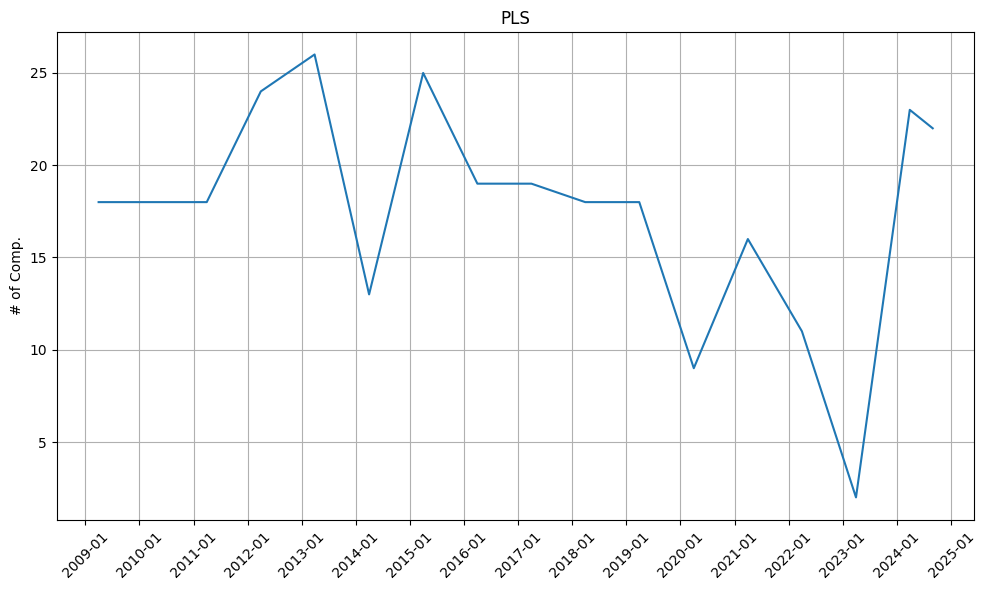

In [ ]:
num_coef = pd.DataFrame(numofc_time.items(), columns=['Identifier', 'num_pls_components'])

num_coef['time'] = num_coef['Identifier'].str.extract(r'numpc\.(\d{4}-\d{2}-\d{2})')

num_coef['time'] = pd.to_datetime(num_coef['time'])

num_coef.drop('Identifier', axis=1, inplace=True)

num_coef.set_index('time', inplace=True)


plt.figure(figsize=(10, 6))
plt.plot(num_coef.index, num_coef['num_pls_components'], linestyle='-')
plt.ylabel('# of Comp.')
plt.title('PLS')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Variable importance

In [5]:
# We only use the last interval:
numofc = list(range(1, 28))


X_train = df_final[variables].loc[(df_final["Date"] >= '2013-02-28') & (df_final["Date"] < '2021-02-28')]
y_train = df_final["Adj Close t+1"].loc[(df_final["Date"]>='2013-02-28') & (df_final["Date"] < '2021-02-28')]

X_val = df_final[variables].loc[(df_final["Date"] >= '2021-02-28') & (df_final["Date"] < '2024-02-28')]
y_val = df_final["Adj Close t+1"].loc[(df_final["Date"] >= '2021-02-28') & (df_final["Date"] < '2024-02-28')]

X_test = df_final[variables].loc[(df_final["Date"] >= '2024-02-28') & (df_final["Date"] < '2025-02-28')]
y_test = df_final["Adj Close t+1"].loc[(df_final["Date"] >= '2024-02-28') & (df_final["Date"] < '2025-02-28')]


mse = np.full((len(numofc),1), np.nan, dtype=np.float32)
    
   
for chars in range(len(numofc)):
    pls_val = PLSRegression(n_components=numofc[chars])
    
    pls_val.fit(X_train, y_train)
    val_pred = pls_val.predict(X_val)
    
    mse[chars,0] = mean_squared_error(y_val, val_pred)

    
best_numofc = numofc[np.argmin(mse)]


pls = PLSRegression(n_components=best_numofc)
pls.fit(X_train, y_train)  

preds = pls.predict(X_test)

R2oos_varimp = 1 - (np.sum(np.power(y_test - preds, 2)) / np.sum(np.power(y_test, 2)))
R2oos_varimp

0.9917792004284993

In [6]:
R2_dic = {}

for variable in variables:
    X_test_copy = X_test.copy()
    
    X_test_copy[variable] = 0
    
    preds = pls.predict(X_test_copy)
    
    R2oos_varimp_each_var = 1 - (np.sum(np.power(y_test - preds, 2)) / np.sum(np.power(y_test, 2)))
    
    R2_dic[variable] = R2oos_varimp_each_var

In [7]:
R2_dic

{'Open': 0.9360210022559361,
 'High': 0.7386795602286023,
 'Low': 0.7457978206563634,
 'Close': 0.9247568234898904,
 'Adj Close': -0.027625079872261038,
 'Volume': 0.991779574097578,
 'Dividends': 0.9917791419621393,
 'Stock Splits': 0.9917785202240553,
 'Market capitalization': 0.9917739847639068,
 'Revenue': 0.9917801489814408,
 'Earnings': 0.9917724764130714,
 'P/E ratio': 0.9917791819168903,
 'P/B ratio': 0.9917792255105105,
 'Operating Margin': 0.9917802141888686,
 'EPS': 0.9917791980048404,
 'Shares Outstanding': 0.9917726565199052,
 'Total assets': 0.9917796691239839,
 'Total liabilities': 0.9917750209157036,
 'Total debt': 0.9917801237036752,
 'Cash on Hand': 0.9917792024263528,
 'Net assets': 0.9917713315099951,
 '1-month momentum': 0.9917861548583129,
 '6-month momentum': 0.9918453301965421,
 '12-month momentum': 0.9918981811855714,
 '36-month momentum': 0.9918502202182449,
 'Book-to-market': 0.99191473022431,
 'Size': 0.9915650991222469}

In [8]:
varimp = pd.DataFrame.from_dict(R2_dic, orient='index', columns=['R2oos']).reset_index()
varimp.rename(columns={'index': 'Variable'}, inplace=True)

varimp['reduc_R2oos'] = R2oos_varimp - varimp['R2oos']

#varimp['reduc_R2oos'] = varimp['reduc_R2oos'].clip(lower=0)

total_reduction = varimp['reduc_R2oos'].sum()
varimp['var_imp'] = varimp['reduc_R2oos'] / total_reduction

varimp = varimp.sort_values(by='var_imp', ascending=False).reset_index(drop=True)

imp = varimp.sort_values('var_imp', ascending=False).head(20)

In [9]:
varimp

,Variable,R2oos,reduc_R2oos,var_imp
0,Adj Close,-0.027625,1.019404e+00,6.211680e-01
1,High,0.738680,2.530996e-01,1.542248e-01
2,Low,0.745798,2.459814e-01,1.498873e-01
3,Close,0.924757,6.702238e-02,4.083969e-02
4,Open,0.936021,5.575820e-02,3.397593e-02
5,Size,0.991565,2.141013e-04,1.304614e-04
6,Net assets,0.991771,7.868919e-06,4.794879e-06
7,Earnings,0.991772,6.724015e-06,4.097239e-06
8,Shares Outstanding,0.991773,6.543909e-06,3.987492e-06
9,Market capitalization,0.991774,5.215665e-06,3.178134e-06


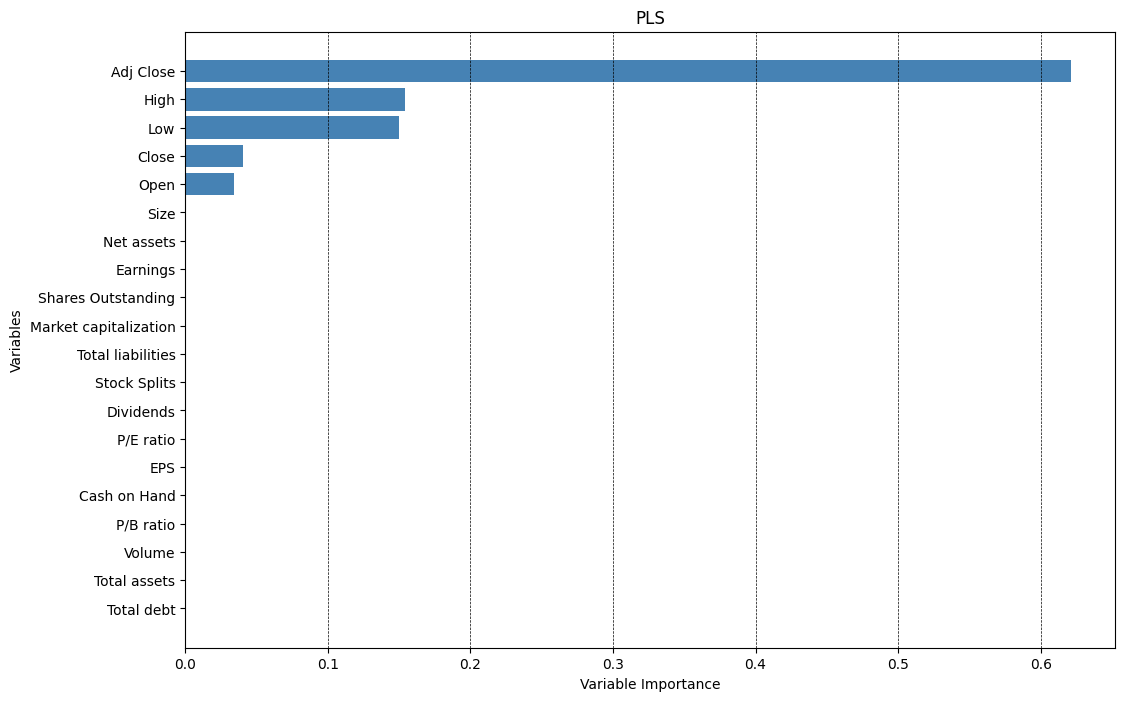

In [96]:
imp = varimp.sort_values('var_imp', ascending=False).head(20)

df_plot = pd.DataFrame({
    'Variable': imp['Variable'],
    'Importance': imp['var_imp']
})

plt.figure(figsize=(12, 8))
plt.barh(df_plot['Variable'], df_plot['Importance'], color='steelblue')
plt.gca().invert_yaxis()


plt.axvline(0.1, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0.2, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0.3, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0.4, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0.5, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0.6, color='black', linestyle='--', linewidth=0.5)



plt.xlabel('Variable Importance')
plt.ylabel('Variables')
plt.title('PLS')

plt.show()

In [10]:
varimp=varimp[["Variable", "var_imp"]]
varimp.to_csv(r'C:/Users/CMert/Documents/Data bachelorprojekt/variable-comparison/varimp PLS.csv', index = False)

# Preparations for machine learning portfolios

In [8]:
# The following is a table comparing the estimiates to the true values of each stock for every day in the test set.

# Remember to rerun df_final for all stock!

symbols = df_final.loc[dates_all.index, 'Symbol']  


comparison = pd.DataFrame({
    'Date': dates_all,  
    'y_hat': predictions_all.tolist(),
    'y_true': y_test_list_all.tolist(),
    'Symbol': symbols  
})


comparison['MonthYear'] = comparison['Date'].dt.to_period('M')

comparison = comparison.sort_values(by=['Date', 'Symbol'], ascending=True)
comparison = comparison.set_index(['MonthYear', 'Symbol'])

comparison

Date      y_hat     y_true
MonthYear Symbol                                 
2008-04   A      2008-04-30  19.611570  23.992857
          AAL    2008-04-30   8.142272   3.733256
          AAON   2008-04-30   3.407494   3.544210
          AAP    2008-04-30  30.987331  35.527317
          AAPL   2008-04-30   5.313416   5.692668
...                     ...        ...        ...
2024-08   ZVIA   2024-08-30   1.333593   1.020000
          ZVRA   2024-08-30   8.005401   7.390000
          ZWS    2024-08-30  33.171405  32.099998
          ZYME   2024-08-30  12.200171  12.100000
          ZYXI   2024-08-30   8.537890   7.960000

[510910 rows x 3 columns]

In [9]:
# Save the df for the Diebold-Mariano test

ols= comparison.reset_index()
ols.to_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/PLS Estimates", index = False)

In [10]:
ols = pd.read_csv("C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/PLS Estimates")

Lad Adj Close være betegnet som P. Afkastraten udregnes ved:

$$ r_{t+1} = \frac{P_{t+1}}{P_t} -1 $$
Og

$$ \hat{r}_{t+1} = \frac{\hat{P}_{t+1}}{P_t} -1 $$

Merafkastsraten udregnes ved:

$$ er_{t+1} = r_{t+1} - r_{f,t+1}  $$
Og

$$ \hat{er}_{t+1} = \hat{r}_{t+1} - r_{f,t+1}  $$


Her er $R_{f,t}$ notation for den risikofrie rate i periode t. Fordi vi arbejder med amerikanske aktier, har vi fundet data for obligationsraten i USA, og benytter dette som den risikofrie rate.
Dataen er fundet her: https://fred.stlouisfed.org/series/DGS20

In [11]:
#Calculate estimiated future return, where distance between each period is one month. Notice that for the return estimate, then for P_t we use the actual adj close price, since at time t it is known: 

comparison = ols

comparison['Date'] = pd.to_datetime(comparison['Date'])


comparison = comparison.sort_values(by=['Symbol', 'Date']).reset_index(drop=True)


comparison["ret_t+1_hat"] = comparison["y_hat"] / comparison.groupby("Symbol")["y_true"].shift(1) - 1
comparison["ret_t+1_true"] = comparison["y_true"] / comparison.groupby("Symbol")["y_true"].shift(1) - 1


comparison_ret_1m = comparison.sort_values(by=['Date', 'Symbol'], ascending=True)


comparison_ret_1m


,MonthYear,Symbol,Date,y_hat,y_true,ret_t+1_hat,ret_t+1_true
0,2008-04,A,2008-04-30,19.611570,23.992857,NaN,NaN
549,2008-04,AAL,2008-04-30,8.142272,3.733256,NaN,NaN
898,2008-04,AAON,2008-04-30,3.407494,3.544210,NaN,NaN
1095,2008-04,AAP,2008-04-30,30.987331,35.527317,NaN,NaN
1292,2008-04,AAPL,2008-04-30,5.313416,5.692668,NaN,NaN
...,...,...,...,...,...,...,...
510411,2024-08,ZVIA,2024-08-30,1.333593,1.020000,0.320389,0.009901
510510,2024-08,ZVRA,2024-08-30,8.005401,7.390000,0.046458,-0.033987
510647,2024-08,ZWS,2024-08-30,33.171405,32.099998,0.022862,-0.010176
510723,2024-08,ZYME,2024-08-30,12.200171,12.100000,0.040083,0.031543


In [12]:
# Drop rows where either 'ret_t-(y_hat)	' or 'ret_t-(y_true)' is NaN
comparison_ret_1m = comparison_ret_1m.dropna(subset=['ret_t+1_hat', 'ret_t+1_true']).reset_index(drop=False)



In [13]:
treasury_securities = pd.read_excel("C:/Users/CMert/Documents/Data bachelorprojekt/Treasury securities.xlsx")

In [14]:
treasury_securities['Date'] = pd.to_datetime(treasury_securities['Date'])
comparison_ret_1m['Date'] = pd.to_datetime(comparison_ret_1m['Date'])

new_comparison = pd.merge(comparison_ret_1m, treasury_securities, on='Date', how='inner')

new_comparison = new_comparison[new_comparison['Treasury Securities'] != 0]

new_comparison['Treasury Securities'] = new_comparison['Treasury Securities'] / (12*100)

new_comparison['exc_ret_t+1_hat'] = new_comparison['ret_t+1_hat']-new_comparison['Treasury Securities']

new_comparison['exc_ret_t+1_true'] = new_comparison['ret_t+1_true']-new_comparison['Treasury Securities']

new_comparison = new_comparison.sort_values(by=['Date', 'Symbol'], ascending=True)

new_comparison = new_comparison.drop("index", axis = 1)

new_comparison


,MonthYear,Symbol,Date,y_hat,y_true,ret_t+1_hat,ret_t+1_true,Treasury Securities,exc_ret_t+1_hat,exc_ret_t+1_true
0,2008-05,A,2008-05-30,23.826692,22.805721,-0.006926,-0.049479,0.003950,-0.010876,-0.053429
1,2008-05,AAL,2008-05-30,4.321730,2.356854,0.157630,-0.368687,0.003950,0.153680,-0.372637
2,2008-05,AAON,2008-05-30,3.891956,3.271587,0.098117,-0.076921,0.003950,0.094167,-0.080871
3,2008-05,AAP,2008-05-30,35.456721,34.281311,-0.001987,-0.035072,0.003950,-0.005937,-0.039022
4,2008-05,AAPL,2008-05-30,6.011967,5.049963,0.056090,-0.112901,0.003950,0.052140,-0.116851
...,...,...,...,...,...,...,...,...,...,...
507062,2024-08,ZVIA,2024-08-30,1.333593,1.020000,0.320389,0.009901,0.003567,0.316823,0.006334
507063,2024-08,ZVRA,2024-08-30,8.005401,7.390000,0.046458,-0.033987,0.003567,0.042891,-0.037554
507064,2024-08,ZWS,2024-08-30,33.171405,32.099998,0.022862,-0.010176,0.003567,0.019295,-0.013742
507065,2024-08,ZYME,2024-08-30,12.200171,12.100000,0.040083,0.031543,0.003567,0.036516,0.027976


In [15]:
# Remember to rerun df_final, when adding 'Market cap' since it is standardized:

new_comparison['Date'] = pd.to_datetime(new_comparison['Date'])
df_final['Date'] = pd.to_datetime(df_final['Date'])

final_comparison = pd.merge(new_comparison, df_final[["Date", "Symbol", "Market capitalization"]], on=["Date", "Symbol"], how="inner")


final_comparison = final_comparison.sort_values(by=['Date', 'Symbol'], ascending=True)

In [16]:
final_comparison = final_comparison.rename(columns={'Treasury Securities' : 'Risk free rate'})

In [17]:
# We now limit the df to the following decade 2014-01 and 2023-12
final_comparison = final_comparison[
    (final_comparison["MonthYear"] >= "2014-01") &
    (final_comparison["MonthYear"] <= "2023-12")
]


In [18]:
final_comparison

,MonthYear,Symbol,Date,y_hat,y_true,ret_t+1_hat,ret_t+1_true,Risk free rate,exc_ret_t+1_hat,exc_ret_t+1_true,Market capitalization
134848,2014-01,A,2014-01-31,37.995458,37.276997,-0.002111,-0.020980,0.002792,-0.004902,-0.023772,1.904000e+10
134849,2014-01,AACG,2014-01-31,0.694317,0.375884,0.985694,0.075000,0.002792,0.982903,0.072208,9.062000e+07
134850,2014-01,AAL,2014-01-31,32.193807,34.815441,0.017858,0.100745,0.002792,0.015066,0.097953,6.590000e+09
134851,2014-01,AAON,2014-01-31,12.957011,12.327587,0.058855,0.007418,0.002792,0.056063,0.004626,1.170000e+09
134852,2014-01,AAP,2014-01-31,104.600734,115.128609,0.007871,0.109311,0.002792,0.005079,0.106519,8.060000e+09
...,...,...,...,...,...,...,...,...,...,...,...
477000,2023-12,ZVIA,2023-12-29,2.439001,1.700000,0.213433,-0.154229,0.003500,0.209933,-0.157729,2.600000e+08
477001,2023-12,ZVRA,2023-12-29,6.524744,5.790000,-0.003856,-0.116031,0.003500,-0.007356,-0.119531,1.583091e+08
477002,2023-12,ZWS,2023-12-29,29.762133,29.427322,0.019631,0.008160,0.003500,0.016131,0.004660,3.760000e+09
477003,2023-12,ZYME,2023-12-29,10.729273,10.840000,0.032654,0.043311,0.003500,0.029154,0.039811,4.900000e+08


In [19]:
# Index every month in order

unique_months = final_comparison['MonthYear'].unique()
unique_months.sort()

month_indices = list(range(1, len(unique_months) + 1))

df_month_merge = pd.DataFrame({
    'MonthYear': unique_months,
    'MonthIndex': month_indices
})

final_comparison = final_comparison.merge(df_month_merge, on='MonthYear', how='left')


In [20]:
final_comparison

,MonthYear,Symbol,Date,y_hat,y_true,ret_t+1_hat,ret_t+1_true,Risk free rate,exc_ret_t+1_hat,exc_ret_t+1_true,Market capitalization,MonthIndex
0,2014-01,A,2014-01-31,37.995458,37.276997,-0.002111,-0.020980,0.002792,-0.004902,-0.023772,1.904000e+10,1
1,2014-01,AACG,2014-01-31,0.694317,0.375884,0.985694,0.075000,0.002792,0.982903,0.072208,9.062000e+07,1
2,2014-01,AAL,2014-01-31,32.193807,34.815441,0.017858,0.100745,0.002792,0.015066,0.097953,6.590000e+09,1
3,2014-01,AAON,2014-01-31,12.957011,12.327587,0.058855,0.007418,0.002792,0.056063,0.004626,1.170000e+09,1
4,2014-01,AAP,2014-01-31,104.600734,115.128609,0.007871,0.109311,0.002792,0.005079,0.106519,8.060000e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...
342152,2023-12,ZVIA,2023-12-29,2.439001,1.700000,0.213433,-0.154229,0.003500,0.209933,-0.157729,2.600000e+08,120
342153,2023-12,ZVRA,2023-12-29,6.524744,5.790000,-0.003856,-0.116031,0.003500,-0.007356,-0.119531,1.583091e+08,120
342154,2023-12,ZWS,2023-12-29,29.762133,29.427322,0.019631,0.008160,0.003500,0.016131,0.004660,3.760000e+09,120
342155,2023-12,ZYME,2023-12-29,10.729273,10.840000,0.032654,0.043311,0.003500,0.029154,0.039811,4.900000e+08,120


In [21]:
# Function to add the decile rank of each stock in each month

def decile_ranks(df):
    df = df.sort_values(by='exc_ret_t+1_hat', ascending=True)
    
    df['Decile rank'] = pd.qcut(df['exc_ret_t+1_hat'], 10, labels=False, duplicates='drop')
    return df


final_comparison = final_comparison.groupby('MonthYear', group_keys=False).apply(decile_ranks)


In [22]:
# A dictionray of the stock history of each decile:

decile_dataframes = {}

# Loop through each decile rank
for decile in range(10):
    
    decile_df = final_comparison[final_comparison['Decile rank'] == decile].copy()
    
    decile_df.reset_index(drop=True, inplace=True)
    
    decile_dataframes[f'decile_rank_{decile}'] = decile_df

In [23]:
decile_dataframes['decile_rank_9']

,MonthYear,Symbol,Date,y_hat,y_true,ret_t+1_hat,ret_t+1_true,Risk free rate,exc_ret_t+1_hat,exc_ret_t+1_true,Market capitalization,MonthIndex,Decile rank
0,2014-01,EQNR,2014-01-31,14.149560,14.618856,0.075261,0.110924,0.002792,0.072469,0.108132,7.707000e+10,1,9
1,2014-01,FSS,2014-01-31,11.703481,11.351810,0.075331,0.043019,0.002792,0.072540,0.040228,9.200000e+08,1,9
2,2014-01,ICL,2014-01-31,5.865434,5.565185,0.077030,0.021897,0.002792,0.074238,0.019106,1.057000e+10,1,9
3,2014-01,LTRX,2014-01-31,2.694080,2.560000,0.077632,0.024000,0.002792,0.074840,0.021208,2.281000e+07,1,9
4,2014-01,HRZN,2014-01-31,5.172099,4.870339,0.077787,0.014905,0.002792,0.074995,0.012113,1.300000e+08,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34253,2023-12,UAMY,2023-12-29,0.754026,0.230000,2.016102,-0.080000,0.003500,2.012602,-0.083500,5.179000e+07,120,9
34254,2023-12,USAS,2023-12-29,0.728199,0.220000,2.034164,-0.083333,0.003500,2.030664,-0.086833,1.000000e+08,120,9
34255,2023-12,ZOM,2023-12-29,0.728879,0.134000,3.338564,-0.202381,0.003500,3.335064,-0.205881,1.500000e+08,120,9
34256,2023-12,SOBR,2023-12-29,2.100303,0.595000,3.656992,0.319291,0.003500,3.653492,0.315791,1.384000e+07,120,9


# Machine learning portfolios

For hvert decildatasæt og derfra for hver måned tilføjer vi to vægte for hver aktie. Vægtene er henholdsvis 'equal weights' og 'market capitalization weights' som udregnes ved:

$$w^{eq} = \frac{1}{N}, $$
hvor N er antallet af aktier for den respektive måned. Vægten baseret på aktiens markedsværdi udregnes ved:

$$w^{mc}_{i} = \frac{mc_i}{\sum_{j = 1}^N mc_j}, $$
hvor $i$ og $j$ er en indexering af aktierne for den respektive måned.

In [24]:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    
    decile_dfs_value.sort_values(['MonthYear'], inplace=True)
    decile_dfs_value.reset_index(drop=True, inplace=True)
    
    # Calculate eq weights:
    decile_dfs_value['eq_weights'] = 1 / decile_dfs_value.groupby('MonthYear')['Symbol'].transform('count')
    
    # Calculate mc weights
    decile_dfs_value['mc_weights'] = decile_dfs_value['Market capitalization'] / decile_dfs_value.groupby('MonthYear')['Market capitalization'].transform('sum')
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

I artiklen S. 2261 (PDF S. 39) er porteføljens merafkastsrate givet ved:

$$\hat{er}^P_{t+1} = \sum_{i = 1}^N w^P_{i,t} \cdot \hat{er}_{i,t+1} , $$
hvor P angiver den enkelte portefølje, specificeret ved variablerne Decile rank og MonthYear.

In [25]:
# Weighted true excess return at t+1 for each stock:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    # Calculate the product of equal weights and excess return, to find the equal weighted excess return of each stock:
    decile_dfs_value['exc_ret_t+1_true_eq'] = decile_dfs_value['exc_ret_t+1_true'] * decile_dfs_value['eq_weights']
    
    
    # Calculate the product of mc weights and excess return, to find the mc weighted excess return of each stock:
    decile_dfs_value['exc_ret_t+1_true_mc'] = decile_dfs_value['exc_ret_t+1_true'] * decile_dfs_value['mc_weights']
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

In [26]:
# Weighted true portfolio excess return at t+1:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    
    decile_dfs_value.sort_values(['MonthYear'], inplace=True)
    decile_dfs_value.reset_index(drop=True, inplace=True)
    
    # Calculate true eq portfolio excess return:
    decile_dfs_value['portfolio_true_exc_ret_eq'] = decile_dfs_value.groupby('MonthYear')['exc_ret_t+1_true_eq'].transform('sum')
    
    # Calculate true mc portfolio excess return:
    decile_dfs_value['portfolio_true_exc_ret_mc'] = decile_dfs_value.groupby('MonthYear')['exc_ret_t+1_true_mc'].transform('sum')
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

In [27]:
# Weighted predicted excess return at t+1 for each stock:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    # Calculate the product of equal weights and excess return, to find the equal weighted excess return of each stock:
    decile_dfs_value['exc_ret_t+1_hat_eq'] = decile_dfs_value['exc_ret_t+1_hat'] * decile_dfs_value['eq_weights']
    
    
    # Calculate the product of mc weights and excess return, to find the mc weighted excess return of each stock:
    decile_dfs_value['exc_ret_t+1_hat_mc'] = decile_dfs_value['exc_ret_t+1_hat'] * decile_dfs_value['mc_weights']
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

In [28]:
# Weighted predicted portfolio excess return at t+1:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    
    decile_dfs_value.sort_values(['MonthYear'], inplace=True)
    decile_dfs_value.reset_index(drop=True, inplace=True)
    
    # Calculate true eq portfolio excess return:
    decile_dfs_value['portfolio_hat_exc_ret_eq'] = decile_dfs_value.groupby('MonthYear')['exc_ret_t+1_hat_eq'].transform('sum')
    
    # Calculate true mc portfolio excess return:
    decile_dfs_value['portfolio_hat_exc_ret_mc'] = decile_dfs_value.groupby('MonthYear')['exc_ret_t+1_hat_mc'].transform('sum')
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

In [29]:
# Weighted true return at t+1 for each stock:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    # Calculate the product of equal weights and return, to find the equal weighted return of each stock:
    decile_dfs_value['ret_t+1_true_eq'] = decile_dfs_value['ret_t+1_true'] * decile_dfs_value['eq_weights']
    
    
    # Calculate the product of mc weights and return, to find the mc weighted return of each stock:
    decile_dfs_value['ret_t+1_true_mc'] = decile_dfs_value['ret_t+1_true'] * decile_dfs_value['mc_weights']
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

In [30]:
# Weighted true portfolio return at t+1:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    
    decile_dfs_value.sort_values(['MonthYear'], inplace=True)
    decile_dfs_value.reset_index(drop=True, inplace=True)
    
    # Calculate true eq portfolio return:
    decile_dfs_value['portfolio_true_ret_eq'] = decile_dfs_value.groupby('MonthYear')['ret_t+1_true_eq'].transform('sum')
    
    # Calculate true mc portfolio return:
    decile_dfs_value['portfolio_true_ret_mc'] = decile_dfs_value.groupby('MonthYear')['ret_t+1_true_mc'].transform('sum')
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

In [31]:
decile_dataframes['decile_rank_5'].columns

Index(['MonthYear', 'Symbol', 'Date', 'y_hat', 'y_true', 'ret_t+1_hat',
       'ret_t+1_true', 'Risk free rate', 'exc_ret_t+1_hat', 'exc_ret_t+1_true',
       'Market capitalization', 'MonthIndex', 'Decile rank', 'eq_weights',
       'mc_weights', 'exc_ret_t+1_true_eq', 'exc_ret_t+1_true_mc',
       'portfolio_true_exc_ret_eq', 'portfolio_true_exc_ret_mc',
       'exc_ret_t+1_hat_eq', 'exc_ret_t+1_hat_mc', 'portfolio_hat_exc_ret_eq',
       'portfolio_hat_exc_ret_mc', 'ret_t+1_true_eq', 'ret_t+1_true_mc',
       'portfolio_true_ret_eq', 'portfolio_true_ret_mc'],
      dtype='object')

In [32]:
portfolio_returns2 = {}

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():

    portfolio_variables = decile_dfs_value[['MonthYear',
                                   
                                   'portfolio_true_exc_ret_eq',
                                   'portfolio_true_exc_ret_mc',
                                   
                                   'portfolio_hat_exc_ret_eq',
                                   'portfolio_hat_exc_ret_mc',
                                   
                                   'portfolio_true_ret_eq',
                                   'portfolio_true_ret_mc',
                                   
                                   'Decile rank',
                                   'MonthIndex',
                                   
                                   ]].copy()
    
    portfolio_variables = portfolio_variables.drop_duplicates()
    
    portfolio_variables.reset_index(drop=True, inplace=True)
    
    portfolio_returns2[decile_dfs_key] = portfolio_variables


In [33]:
portfolio_returns2['decile_rank_9']

,MonthYear,portfolio_true_exc_ret_eq,portfolio_true_exc_ret_mc,portfolio_hat_exc_ret_eq,portfolio_hat_exc_ret_mc,portfolio_true_ret_eq,portfolio_true_ret_mc,Decile rank,MonthIndex
0,2014-01,0.105455,0.052160,0.176037,0.155807,0.108247,0.054952,9,1
1,2014-02,0.058433,0.017052,0.155504,0.136247,0.061191,0.019811,9,2
2,2014-03,0.016822,0.015129,0.154218,0.141740,0.019580,0.017887,9,3
3,2014-04,0.014973,0.021673,0.252325,0.126689,0.017656,0.024356,9,4
4,2014-05,0.073783,0.034101,0.267103,0.126303,0.076325,0.036643,9,5
...,...,...,...,...,...,...,...,...,...
115,2023-08,-0.025175,-0.054423,0.358815,0.267126,-0.021516,-0.050764,9,116
116,2023-09,-0.107801,-0.104225,0.400237,0.310182,-0.103701,-0.100125,9,117
117,2023-10,0.190010,0.162070,0.477950,0.375138,0.194352,0.166412,9,118
118,2023-11,0.216739,0.201314,0.412734,0.326013,0.220672,0.205247,9,119


Pr. vores finansieringsbog, så gælder: "For any portfolio, P, we define the Sharpe-ratio as excess return relative to standard deviation", jf. S. 57, "Finance 1 and Beyond":

$$Sharpe-ratio^P = \frac{er^P_{t+1}}{\sigma_R^P}$$

In [34]:
#Find Sharpe-ratio of each decile rank dataframe:

for decile_key, portfolio_df in portfolio_returns2.items():
    
    # Calculate average of the true portfolio excess return
    mean_ER_true_eq = portfolio_df['portfolio_true_exc_ret_eq'].mean()
    mean_ER_true_mc = portfolio_df['portfolio_true_exc_ret_mc'].mean()
    
    # Calculate average of the predicted portfolio excess return
    mean_ER_pred_eq = portfolio_df['portfolio_hat_exc_ret_eq'].mean()
    mean_ER_pred_mc = portfolio_df['portfolio_hat_exc_ret_mc'].mean()
    
    # Calculate standard deviation of the true portfolio excess returns
    std_R_true_eq = portfolio_df['portfolio_true_ret_eq'].std()
    std_R_true_mc = portfolio_df['portfolio_true_ret_mc'].std()
    
    # Calculate annualized Sharpe ratio of the true excess returns
    sharpe_ratio_eq = (mean_ER_true_eq / std_R_true_eq) * np.sqrt(12)
    sharpe_ratio_mc = (mean_ER_true_mc / std_R_true_mc) * np.sqrt(12)
    
   
    portfolio_df['Mean_true_ER_eq'] = mean_ER_true_eq
    portfolio_df['Mean_true_ER_mc'] = mean_ER_true_mc
    portfolio_df['Mean_pred_ER_eq'] = mean_ER_pred_eq
    portfolio_df['Mean_pred_ER_mc'] = mean_ER_pred_mc
    portfolio_df['Std_true_ER_eq'] = std_R_true_eq
    portfolio_df['Std_true_ER_mc'] = std_R_true_mc
    portfolio_df['Sharpe_ratio_eq'] = sharpe_ratio_eq
    portfolio_df['Sharpe_ratio_mc'] = sharpe_ratio_mc
    

    portfolio_returns2[decile_key] = portfolio_df

# Zero-net-investment long-short portfolios

At shorte en aktie betyder at du låner aktier, som du vælger at sælge, fordi du forudsiger at de vil falde i pris og dermed kan du købe dem billiger og tjene differencen. At longe en aktie betyder at du køber en aktie, fordi du forventer den stiger i pris og dermed kan tjene differencen. Derfor vil man ifølge zero-net-investment teorien bruge alle ens penge på long-investment, hvor pengene kommer af de aktier man lige har shortet. Dvs. til tid 0 skal ens portefølje have følgende værdi:

$$\sum_{i = 1}^N w_i \cdot P^{long}_{i,0} - \sum_{j = 1}^M w_j \cdot P^{short}_{j,0} = 0$$
Her vælges vægtene for både short- og long-aktierne som før, hvor summen af alle vægte skal være 1. Afkastet for zero-net-investment er dermed til tid t givet ved:

$$\sum_{i = 1}^N w_i \cdot P^{long}_{i,t} - \sum_{j = 1}^M w_j \cdot P^{short}_{j,t} = profit$$

In [35]:
# Create the tables that show the performance of the machine learning portfolios

long_df = portfolio_returns2['decile_rank_9'].copy()
short_df = portfolio_returns2['decile_rank_0'].copy()

long_df['Investment type'] = 'long'
short_df['Investment type'] = 'short'


calc_df = pd.merge(long_df, short_df, on='MonthIndex', suffixes=('_long', '_short'))

In [36]:

# Calculate zero-net investment excess returns
calc_df['true_ER_zni_eq'] = calc_df['portfolio_true_exc_ret_eq_long'] - calc_df['portfolio_true_exc_ret_eq_short']
calc_df['true_ER_zni_mc'] = calc_df['portfolio_true_exc_ret_mc_long'] - calc_df['portfolio_true_exc_ret_mc_short']
calc_df['pred_ER_zni_eq'] = calc_df['portfolio_hat_exc_ret_eq_long'] - calc_df['portfolio_hat_exc_ret_eq_short']
calc_df['pred_ER_zni_mc'] = calc_df['portfolio_hat_exc_ret_mc_long'] - calc_df['portfolio_hat_exc_ret_mc_short']

# Calculate the means
mean_true_ER_zni_eq = calc_df['true_ER_zni_eq'].mean()
mean_true_ER_zni_mc = calc_df['true_ER_zni_mc'].mean()

mean_pred_ER_zni_eq = calc_df['pred_ER_zni_eq'].mean()
mean_pred_ER_zni_mc = calc_df['pred_ER_zni_mc'].mean()

# # Calculate zero-net investment returns that we need for Sharpe ratio
calc_df['true_R_zni_eq'] = calc_df['portfolio_true_ret_eq_long'] - calc_df['portfolio_true_ret_eq_short']
calc_df['true_R_zni_mc'] = calc_df['portfolio_true_ret_mc_long'] - calc_df['portfolio_true_ret_mc_short']


std_true_R_zni_eq = calc_df['true_R_zni_eq'].std()
std_true_R_zni_mc = calc_df['true_R_zni_mc'].std()

# Sharpe ratio
sharpe_ratio_eq_zni = (mean_true_ER_zni_eq / std_true_R_zni_eq) * np.sqrt(12)
sharpe_ratio_mc_zni = (mean_true_ER_zni_mc / std_true_R_zni_mc) * np.sqrt(12)




In [37]:
calc_df

,MonthYear_long,portfolio_true_exc_ret_eq_long,portfolio_true_exc_ret_mc_long,portfolio_hat_exc_ret_eq_long,portfolio_hat_exc_ret_mc_long,portfolio_true_ret_eq_long,portfolio_true_ret_mc_long,Decile rank_long,MonthIndex,Mean_true_ER_eq_long,...,Std_true_ER_mc_short,Sharpe_ratio_eq_short,Sharpe_ratio_mc_short,Investment type_short,true_ER_zni_eq,true_ER_zni_mc,pred_ER_zni_eq,pred_ER_zni_mc,true_R_zni_eq,true_R_zni_mc
0,2014-01,0.105455,0.052160,0.176037,0.155807,0.108247,0.054952,9,1,0.130979,...,0.073115,-1.953841,-1.322842,short,0.077517,0.029150,0.224680,0.195304,0.077517,0.029150
1,2014-02,0.058433,0.017052,0.155504,0.136247,0.061191,0.019811,9,2,0.130979,...,0.073115,-1.953841,-1.322842,short,0.121500,0.053978,0.215435,0.192466,0.121500,0.053978
2,2014-03,0.016822,0.015129,0.154218,0.141740,0.019580,0.017887,9,3,0.130979,...,0.073115,-1.953841,-1.322842,short,0.094139,0.017234,0.205703,0.186880,0.094139,0.017234
3,2014-04,0.014973,0.021673,0.252325,0.126689,0.017656,0.024356,9,4,0.130979,...,0.073115,-1.953841,-1.322842,short,0.043216,0.029426,0.305133,0.163890,0.043216,0.029426
4,2014-05,0.073783,0.034101,0.267103,0.126303,0.076325,0.036643,9,5,0.130979,...,0.073115,-1.953841,-1.322842,short,0.047607,0.009177,0.321274,0.164913,0.047607,0.009177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2023-08,-0.025175,-0.054423,0.358815,0.267126,-0.021516,-0.050764,9,116,0.130979,...,0.073115,-1.953841,-1.322842,short,0.063448,-0.016338,0.678209,0.298038,0.063447,-0.016338
116,2023-09,-0.107801,-0.104225,0.400237,0.310182,-0.103701,-0.100125,9,117,0.130979,...,0.073115,-1.953841,-1.322842,short,0.004086,-0.041582,0.751351,0.331505,0.004086,-0.041582
117,2023-10,0.190010,0.162070,0.477950,0.375138,0.194352,0.166412,9,118,0.130979,...,0.073115,-1.953841,-1.322842,short,0.128688,0.070138,1.025638,0.406299,0.128688,0.070138
118,2023-11,0.216739,0.201314,0.412734,0.326013,0.220672,0.205247,9,119,0.130979,...,0.073115,-1.953841,-1.322842,short,0.145309,0.131494,1.049322,0.367912,0.145309,0.131494


In [38]:
performance_data = []

for i in range(10):
    decile_key = f'decile_rank_{i}'
    decile_df = portfolio_returns2[decile_key]
    
    mean_pred_ER_eq = decile_df['Mean_pred_ER_eq'].iloc[0]
    mean_true_ER_eq = decile_df['Mean_true_ER_eq'].iloc[0]
    std_true_ER_eq = decile_df['Std_true_ER_eq'].iloc[0]
    sharpe_ratio_eq = decile_df['Sharpe_ratio_eq'].iloc[0]
    
    performance_data.append([mean_pred_ER_eq, mean_true_ER_eq, std_true_ER_eq, sharpe_ratio_eq])

# The zero-net-investments caluclations will be used as H-L row
performance_data.append([mean_pred_ER_zni_eq, mean_true_ER_zni_eq, std_true_R_zni_eq, sharpe_ratio_eq_zni])


columns = ['Pred Avg', 'True Avg', 'SD', 'SR']
index = ['Low(L)', '1', '2', '3', '4', '5', '6', '7', '8', 'High(H)', 'H-L']

ML_performance_eq_table = pd.DataFrame(performance_data, columns=columns, index=index)



In [39]:
ML_performance_eq_table

,Pred Avg,True Avg,SD,SR
Low(L),-0.196141,-0.046078,0.081694,-1.953841
1,-0.052152,-0.023197,0.060831,-1.320974
2,-0.029991,-0.010930,0.054725,-0.691871
3,-0.016748,-0.002262,0.053649,-0.146064
4,-0.006483,0.006256,0.052449,0.413189
5,0.003146,0.013078,0.051308,0.882978
6,0.014133,0.019003,0.055467,1.186787
7,0.029207,0.026230,0.059942,1.515874
8,0.057078,0.035790,0.065671,1.887893
High(H),0.681526,0.130979,0.425634,1.066000


In [40]:
performance_data = []

for i in range(10):
    decile_key = f'decile_rank_{i}'
    decile_df = portfolio_returns2[decile_key]
    
    mean_pred_ER_mc = decile_df['Mean_pred_ER_mc'].iloc[0]
    mean_true_ER_mc = decile_df['Mean_true_ER_mc'].iloc[0]
    std_true_ER_mc = decile_df['Std_true_ER_mc'].iloc[0]
    sharpe_ratio_mc = decile_df['Sharpe_ratio_mc'].iloc[0]
    
    performance_data.append([mean_pred_ER_mc, mean_true_ER_mc, std_true_ER_mc, sharpe_ratio_mc])

# The zero-net-investments caluclations will be used as H-L row
performance_data.append([mean_pred_ER_zni_mc, mean_true_ER_zni_mc, std_true_R_zni_mc, sharpe_ratio_mc_zni])

columns = ['Pred Avg', 'True Avg', 'SD', 'SR']
index = ['Low(L)', '1', '2', '3', '4', '5', '6', '7', '8', 'High(H)', 'H-L']

ML_performance_mc_table = pd.DataFrame(performance_data, columns=columns, index=index)

In [41]:
ML_performance_mc_table

,Pred Avg,True Avg,SD,SR
Low(L),-0.226088,-0.027921,0.073115,-1.322842
1,-0.051310,-0.017680,0.056538,-1.083294
2,-0.029666,-0.006302,0.050468,-0.432590
3,-0.016765,0.001072,0.046970,0.079085
4,-0.006450,0.009827,0.046067,0.738940
5,0.003026,0.015420,0.044151,1.209850
6,0.013916,0.023738,0.050970,1.613303
7,0.028897,0.027574,0.051580,1.851873
8,0.055136,0.033932,0.061747,1.903629
High(H),0.156113,0.041971,0.093506,1.554907


In [42]:
ML_performance_eq_table.to_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/PLS_eq.csv")
ML_performance_mc_table.to_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/PLS_mc.csv")

# The second table of the machine learning portfolios performance

Maximum drawdown er i artiklen defineret ved:

$$MaxDD = \max _{0 \leq t_{1} \leq t_{2} \leq T}\left(Y_{t_{1}}-Y_{t_{2}}\right),  $$
hvor $Y_t$ er den akkumulerede log afkast givet ved:

$$ r = \log\left(\prod_{i = 1}^{n}(1+r_i) \right)$$

$$ = \sum_{i = 1}^{n} \log \left( 1+r_i \right), $$
hvor n er antallet af porteføljer

In [43]:

# Calculate the maximum drawdown
def max_dd(returns):
    
    draw_downs = []
    exc_ret = returns.copy()
    
    # Calculate cumulative log excess returns
    exc_ret = np.log(1 + exc_ret).cumsum()
    
    
    peak = exc_ret.iloc[0]
    
    for i in range(1, len(exc_ret)):
        current = exc_ret.iloc[i]
        
        if current > peak:
            peak = current  
        else:
            drawdown = peak - current  
            draw_downs.append(drawdown)
    
    if draw_downs:
        max_drawdown = max(draw_downs)
    else:
        max_drawdown = 0  # In the off chance the stock is ever increasing
    
    return max_drawdown

maxdd_eq = max_dd(calc_df['true_ER_zni_eq'])
maxdd_mc = max_dd(calc_df['true_ER_zni_mc'])


maxdd_eq_pct = maxdd_eq * 100
maxdd_mc_pct = maxdd_mc * 100

print("MaxDD EQ: ", maxdd_eq_pct)
print("MaxDD MC: ", maxdd_mc_pct)

MaxDD EQ:  29.241753207654675
MaxDD MC:  28.145021967207917


# Max 1M loss
I artiklen defineret som den mest extreme, negative månedlige afkast.

In [44]:
max_1m_loss_eq_pct = calc_df['true_ER_zni_eq'].min()*(-100)
max_1m_loss_mc_pct = calc_df['true_ER_zni_mc'].min()*(-100)

print("Max 1M EQ: ", max_1m_loss_eq_pct)
print("Max 1M MC: ", max_1m_loss_mc_pct)

Max 1M EQ:  24.911200911858977
Max 1M MC:  10.5565296225803


# Turnover

I artiklen er turnover defineret ved:

$$ \frac{1}{T} \sum_{t = 1}^T \left(\sum_{i = 1}^n   \bigg| w_{i,t+1} - \frac{w_{i,t}(1+r_{i,t+1})}{1+ \sum_{j = 1}^n  w_{j,t} \cdot r_{j,t+1}}  \bigg|  \right)  $$

In [45]:
# Get the t+1 weights for both eq and mc weights:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    
    decile_dfs_value.sort_values(['Symbol', 'MonthYear'], inplace=True)
    decile_dfs_value.reset_index(drop=True, inplace=True)
    
    # Create next month's weights for eq_weights and mc_weights, and if they dont exist set to 0
    decile_dfs_value['eq_weights_t+1'] = decile_dfs_value.groupby('Symbol')['eq_weights'].shift(-1).fillna(0)
    decile_dfs_value['mc_weights_t+1'] = decile_dfs_value.groupby('Symbol')['mc_weights'].shift(-1).fillna(0)

    
    decile_dataframes[decile_dfs_key] = decile_dfs_value


In [46]:
def turnover(long_df, short_df, weight_t0, weight_t1, exc_ret_t1):
    turnover_each_month = []
    
    # Combine long and short portfolios into one portfolio
    zero_net = pd.concat([long_df, short_df], ignore_index=True)
    
    zero_net.sort_values(['MonthYear'], inplace=True)
    zero_net.reset_index(drop=True, inplace=True)
    
    months = zero_net['MonthYear'].unique()
    
    for t in months[:-1]:  # Exclude the last month since it has no t+1 weights
        
        current_month = zero_net[zero_net['MonthYear'] == t]
        
        # Calculate the denominator for month t
        denominator = 1 + (current_month[weight_t0] * current_month[exc_ret_t1]).sum()
        
        # Calculate the turnover for each stock
        current_month['fraction'] = (
            current_month[weight_t0] * (1 + current_month[exc_ret_t1]) / denominator
        )
        current_month['abs_diff'] = abs(
            current_month[weight_t1] - current_month['fraction']
        )
        
        # Sum the absolute differences for month t
        turnover_each_month.append(current_month['abs_diff'].sum())
    
    # Calculate the average turnover across all months
    turnover = sum(turnover_each_month) / len(turnover_each_month)
    return turnover


In [47]:
long_df = decile_dataframes['decile_rank_9']
short_df = decile_dataframes['decile_rank_0']


weight_eq = 'eq_weights'
weight_t1_eq = 'eq_weights_t+1'
exc_ret_t1 = 'exc_ret_t+1_true'

turnover_eq = turnover(long_df, short_df, weight_eq, weight_t1_eq, exc_ret_t1)


weight_mc = 'mc_weights'
weight_t1_mc = 'mc_weights_t+1'
exc_ret_t1 = 'exc_ret_t+1_true'

turnover_mc = turnover(long_df, short_df, weight_mc, weight_t1_mc, exc_ret_t1)


turnover_eq_pct = turnover_eq*100
turnover_mc_pct = turnover_mc*100

print("Turnover EQ: ", turnover_eq_pct)
print("Turnover MC: ", turnover_mc_pct)


Turnover EQ:  46.42064788475403
Turnover MC:  71.70266264552816


In [49]:
eq_table_OLS = pd.DataFrame({
    "PLS" : [maxdd_eq_pct,
                max_1m_loss_eq_pct,
                turnover_eq_pct
                ]
})


eq_table_OLS.index = ['Max DD(%)', "Max 1M loss(%)", "Turnover(%)"]

In [50]:
eq_table_OLS

,PLS
Max DD(%),29.241753
Max 1M loss(%),24.911201
Turnover(%),46.420648


In [51]:
mc_table_OLS = pd.DataFrame({
    "PLS" : [maxdd_mc_pct,
                max_1m_loss_mc_pct,
                turnover_mc_pct
                ]
})


mc_table_OLS.index = ['Max DD(%)', "Max 1M loss(%)", "Turnover(%)"]

In [52]:
mc_table_OLS

,PLS
Max DD(%),28.145022
Max 1M loss(%),10.556530
Turnover(%),71.702663


In [53]:
eq_table_OLS.to_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML Performance tables/PLS_eq.csv")
mc_table_OLS.to_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML Performance tables/PLS_mc.csv")

# Cumulative log returns of portfolio rank 0 and 9

In [54]:
calc_df

,MonthYear_long,portfolio_true_exc_ret_eq_long,portfolio_true_exc_ret_mc_long,portfolio_hat_exc_ret_eq_long,portfolio_hat_exc_ret_mc_long,portfolio_true_ret_eq_long,portfolio_true_ret_mc_long,Decile rank_long,MonthIndex,Mean_true_ER_eq_long,...,Std_true_ER_mc_short,Sharpe_ratio_eq_short,Sharpe_ratio_mc_short,Investment type_short,true_ER_zni_eq,true_ER_zni_mc,pred_ER_zni_eq,pred_ER_zni_mc,true_R_zni_eq,true_R_zni_mc
0,2014-01,0.105455,0.052160,0.176037,0.155807,0.108247,0.054952,9,1,0.130979,...,0.073115,-1.953841,-1.322842,short,0.077517,0.029150,0.224680,0.195304,0.077517,0.029150
1,2014-02,0.058433,0.017052,0.155504,0.136247,0.061191,0.019811,9,2,0.130979,...,0.073115,-1.953841,-1.322842,short,0.121500,0.053978,0.215435,0.192466,0.121500,0.053978
2,2014-03,0.016822,0.015129,0.154218,0.141740,0.019580,0.017887,9,3,0.130979,...,0.073115,-1.953841,-1.322842,short,0.094139,0.017234,0.205703,0.186880,0.094139,0.017234
3,2014-04,0.014973,0.021673,0.252325,0.126689,0.017656,0.024356,9,4,0.130979,...,0.073115,-1.953841,-1.322842,short,0.043216,0.029426,0.305133,0.163890,0.043216,0.029426
4,2014-05,0.073783,0.034101,0.267103,0.126303,0.076325,0.036643,9,5,0.130979,...,0.073115,-1.953841,-1.322842,short,0.047607,0.009177,0.321274,0.164913,0.047607,0.009177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2023-08,-0.025175,-0.054423,0.358815,0.267126,-0.021516,-0.050764,9,116,0.130979,...,0.073115,-1.953841,-1.322842,short,0.063448,-0.016338,0.678209,0.298038,0.063447,-0.016338
116,2023-09,-0.107801,-0.104225,0.400237,0.310182,-0.103701,-0.100125,9,117,0.130979,...,0.073115,-1.953841,-1.322842,short,0.004086,-0.041582,0.751351,0.331505,0.004086,-0.041582
117,2023-10,0.190010,0.162070,0.477950,0.375138,0.194352,0.166412,9,118,0.130979,...,0.073115,-1.953841,-1.322842,short,0.128688,0.070138,1.025638,0.406299,0.128688,0.070138
118,2023-11,0.216739,0.201314,0.412734,0.326013,0.220672,0.205247,9,119,0.130979,...,0.073115,-1.953841,-1.322842,short,0.145309,0.131494,1.049322,0.367912,0.145309,0.131494


<Axes: xlabel='MonthYear_long'>

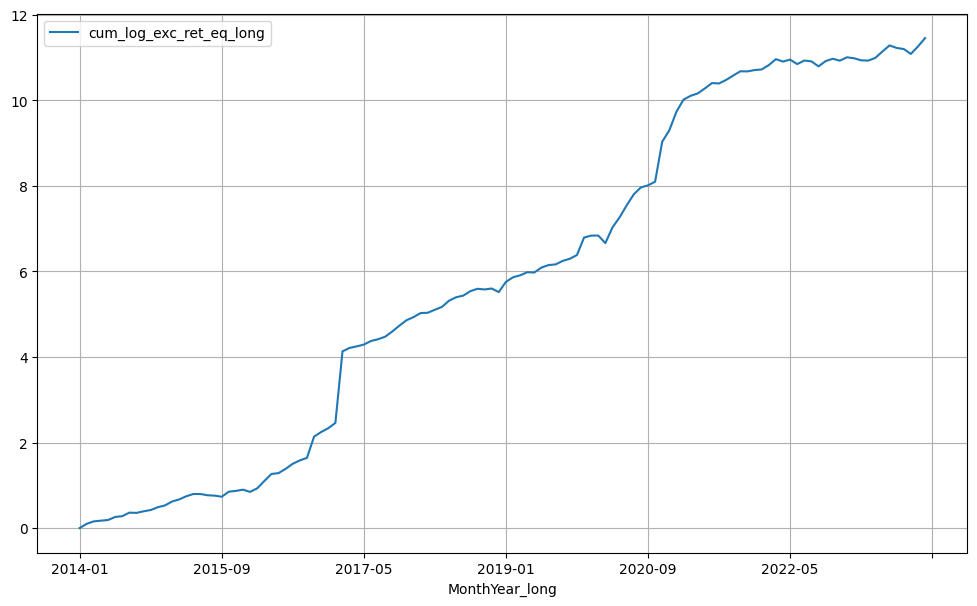

In [55]:
long_df = calc_df.copy()


long_df = long_df.set_index("MonthYear_long")
long_df.sort_values(['MonthYear_long'], inplace = True)


long_df['true_exc_ret_eq_t'] = long_df['portfolio_true_exc_ret_eq_long'].shift(1)


long_df['cum_log_exc_ret_eq_long'] =(np.log(1 + long_df['true_exc_ret_eq_t'])).cumsum()

long_df['cum_log_exc_ret_eq_long'].iloc[0] = 0


long_df[['cum_log_exc_ret_eq_long']].plot(grid=True, figsize=(12, 7))




<Axes: xlabel='MonthYear_long'>

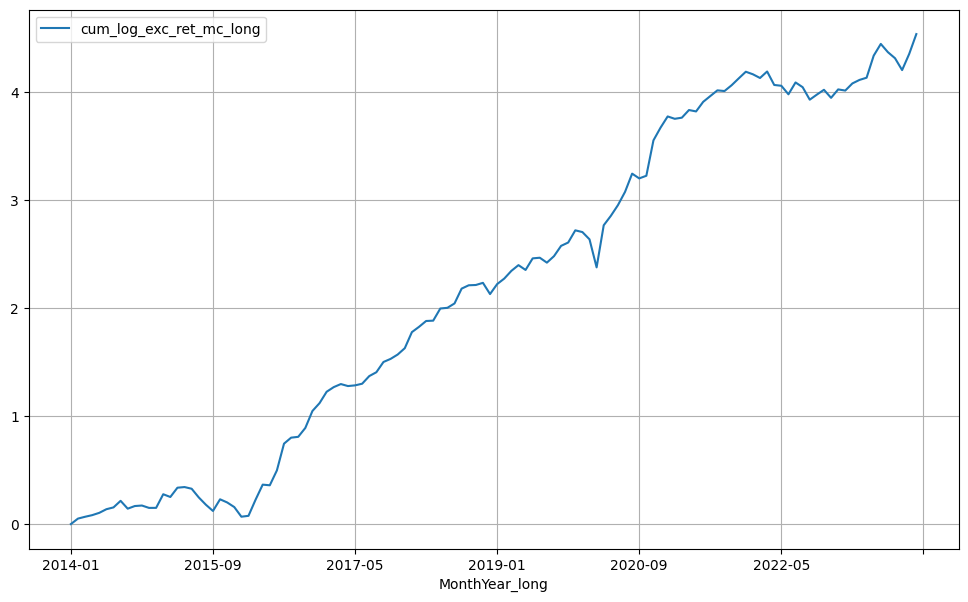

In [59]:
long_df = calc_df.copy()


long_df = long_df.set_index("MonthYear_long")
long_df.sort_values(['MonthYear_long'], inplace = True)


long_df['true_exc_ret_mc_t'] = long_df['portfolio_true_exc_ret_mc_long'].shift(1)


long_df['cum_log_exc_ret_mc_long'] =(np.log(1 + long_df['true_exc_ret_mc_t'])).cumsum()

long_df['cum_log_exc_ret_mc_long'].iloc[0] = 0

long_df[['cum_log_exc_ret_mc_long']].plot(grid=True, figsize=(12, 7))




<Axes: xlabel='MonthYear_short'>

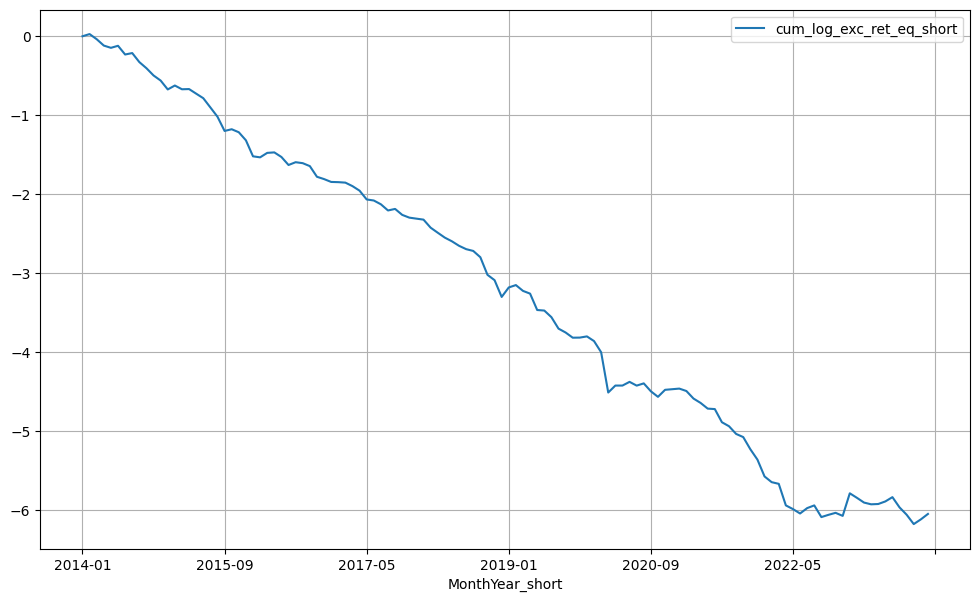

In [56]:
short_df = calc_df.copy()


short_df = long_df.set_index("MonthYear_short")
short_df.sort_values(['MonthYear_short'], inplace = True)


short_df['true_exc_ret_eq_t'] = short_df['portfolio_true_exc_ret_eq_short'].shift(1)


short_df['cum_log_exc_ret_eq_short'] = (np.log(1 + short_df['true_exc_ret_eq_t'])).cumsum()

short_df['cum_log_exc_ret_eq_short'].iloc[0] = 0


short_df[['cum_log_exc_ret_eq_short']].plot(grid=True, figsize=(12, 7))




<Axes: xlabel='MonthYear_short'>

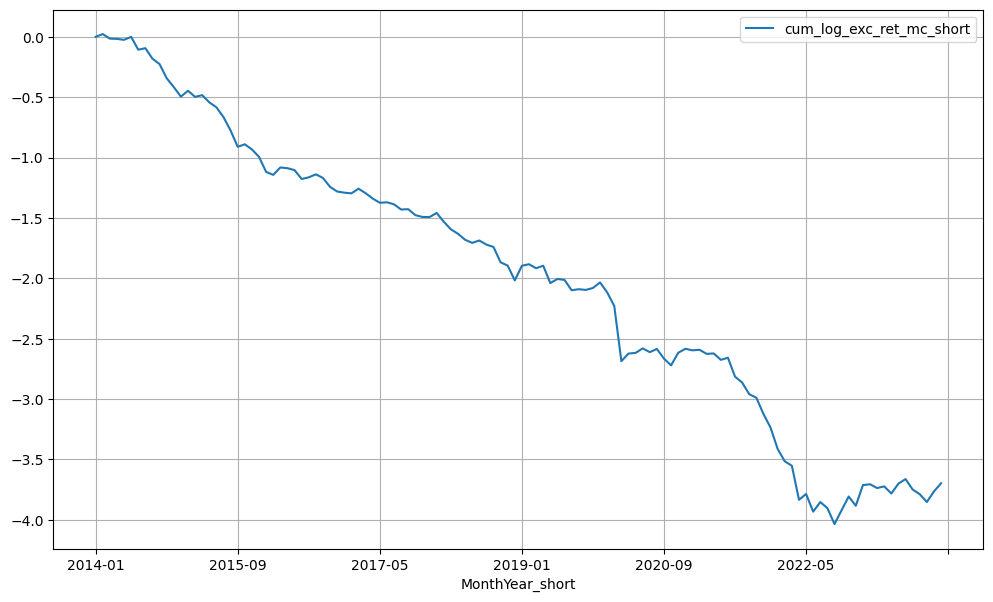

In [60]:
short_df = calc_df.copy()


short_df = long_df.set_index("MonthYear_short")
short_df.sort_values(['MonthYear_short'], inplace = True)


short_df['true_exc_ret_mc_t'] = short_df['portfolio_true_exc_ret_mc_short'].shift(1)


short_df['cum_log_exc_ret_mc_short'] = (np.log(1 + short_df['true_exc_ret_mc_t'])).cumsum()

short_df['cum_log_exc_ret_mc_short'].iloc[0] = 0


short_df[['cum_log_exc_ret_mc_short']].plot(grid=True, figsize=(12, 7))




<Axes: xlabel='MonthYear_long'>

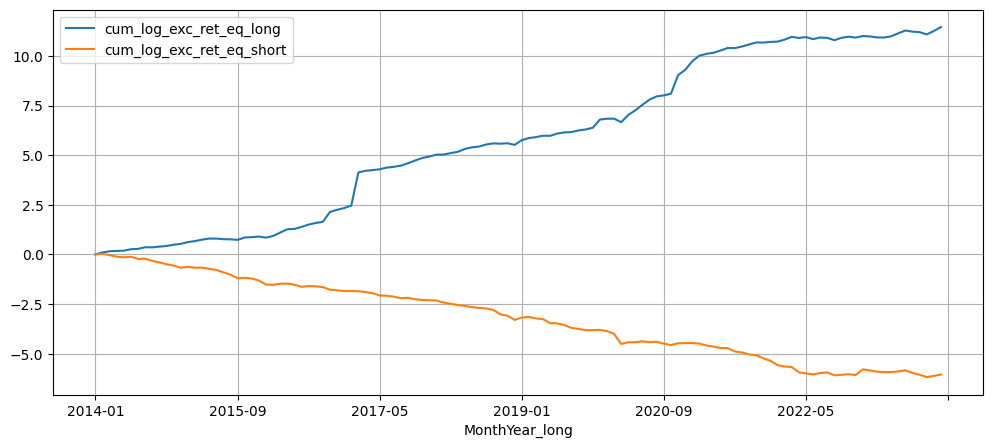

In [57]:
long_short_OLS_eq = pd.merge(long_df[['cum_log_exc_ret_eq_long']], short_df[['cum_log_exc_ret_eq_short']],left_index=True, right_index=True)


long_short_OLS_eq[["cum_log_exc_ret_eq_long", "cum_log_exc_ret_eq_short"]].plot(grid=True,figsize=(12, 5))

In [58]:
long_short_OLS_eq.to_csv(r'C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/PLS eq.csv')

<Axes: xlabel='MonthYear_long'>

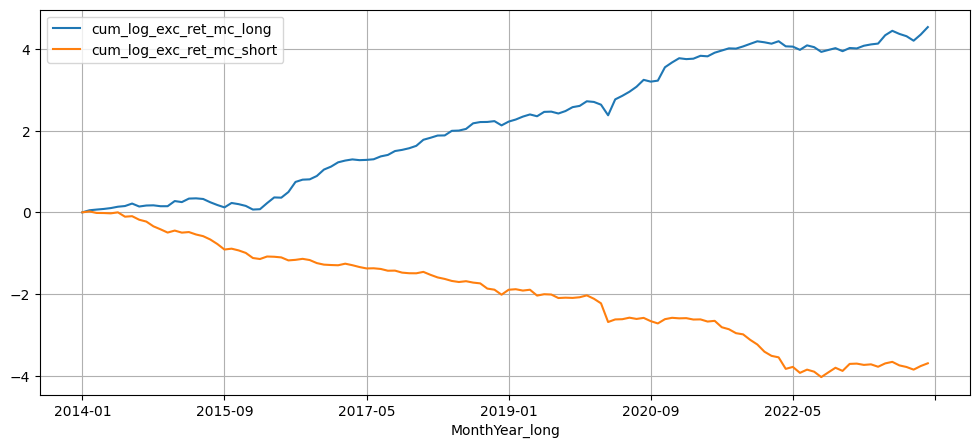

In [61]:

long_short_OLS_mc = pd.merge(long_df[['cum_log_exc_ret_mc_long']], short_df[['cum_log_exc_ret_mc_short']],left_index=True, right_index=True)


long_short_OLS_mc[["cum_log_exc_ret_mc_long", "cum_log_exc_ret_mc_short"]].plot(grid=True,figsize=(12, 5))

In [62]:
long_short_OLS_mc.to_csv(r'C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/PLS mc.csv')

# Graveyard